<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Image_Data/ModelComparisonEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluation Metrics for each model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import torch
import timm
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# **Defining Dataset and Class Weights**

In [ ]:
# Paths
image_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"
metadata_path = "/content/drive/MyDrive/Final Year Project/Data/PAD/Metadata/metadata.csv"

# Load metadata
metadata_df = pd.read_csv(metadata_path)

# Encode class labels
label_encoder = LabelEncoder()
metadata_df["label_encoded"] = label_encoder.fit_transform(metadata_df["diagnostic"].str.upper())
class_names = label_encoder.classes_
num_classes = len(class_names)
print("Classes:", class_names)

# Image size
img_size = 224

# Unified transforms for training and validation
unified_train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

unified_val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class SkinCancerDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["img_id"])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_path} | {e}")
            image = Image.new("RGB", (224, 224))

        label = row["label_encoded"]

        if self.transform:
            image = self.transform(image)

        return image, label

# Split into train/val
train_df, val_df = train_test_split(metadata_df, test_size=0.2, stratify=metadata_df["label_encoded"], random_state=42)

# Datasets
train_dataset = SkinCancerDataset(train_df, image_dir, transform=unified_train_transforms)
val_dataset = SkinCancerDataset(val_df, image_dir, transform=unified_val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Classes: ['ACK' 'BCC' 'MEL' 'NEV' 'SCC' 'SEK']


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(metadata_df["label_encoded"]),
    y=metadata_df["label_encoded"]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Configuration
checkpoint_dir = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/ResNet50V2"
model_name = "resnetv2_50x1_bitm"
num_classes = len(class_names)

# **Evaluation Function**

In [ ]:
def evaluate_all_checkpoints(
    checkpoint_dir,
    model_name,
    val_loader,
    num_classes,
    device,
    class_names=None,
    file_prefix="pytorch_resnet50v2_epoch",
    file_suffix=".pth",
    epoch_range=(1, 11),
    plot=True
):

    val_accuracies = []
    val_losses = []
    epoch_numbers = []

    for epoch in range(*epoch_range):
        filename = f"{file_prefix}{epoch}{file_suffix}"
        path = os.path.join(checkpoint_dir, filename)

        if not os.path.exists(path):
            print(f"Skipping missing checkpoint: {filename}")
            continue

        # Load model
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
        model.load_state_dict(torch.load(path, map_location=device))
        model = model.to(device)
        model.eval()

        all_preds = []
        all_labels = []
        running_loss, total = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / total
        val_acc = accuracy_score(all_labels, all_preds)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_numbers.append(epoch)

        print(f"Epoch {epoch} — Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Plot
    if plot:
        plt.figure()
        plt.plot(epoch_numbers, val_accuracies, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Validation Accuracy")
        plt.title("Validation Accuracy Over Epochs")
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(epoch_numbers, val_losses, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")
        plt.title("Validation Loss Over Epochs")
        plt.grid(True)
        plt.show()

    # Best epoch summary
    best_idx = int(np.argmax(val_accuracies))
    best_epoch = epoch_numbers[best_idx]
    best_acc = val_accuracies[best_idx]
    print(f"\n Best Epoch: {best_epoch} with Accuracy: {best_acc:.4f}")

    return {
        "epochs": epoch_numbers,
        "val_accuracies": val_accuracies,
        "val_losses": val_losses,
        "best_epoch": best_epoch,
        "best_accuracy": best_acc
    }

In [ ]:
def evaluate_model_from_checkpoint(
    checkpoint_path,
    model_name,
    num_classes,
    val_loader,
    device,
    class_names=None,
    plot_title=None
):

    # Load model
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    # Get predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Report
    print(f"\n Classification Report for {os.path.basename(checkpoint_path)}:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.title(plot_title or f"Confusion Matrix — {os.path.basename(checkpoint_path)}")
    plt.tight_layout()
    plt.show()

# **Models**

**DenseNet121**


 Classification Report for pytorch_densenet121_best.pth:
              precision    recall  f1-score   support

         ACK       0.81      0.68      0.74       146
         BCC       0.71      0.77      0.74       169
         MEL       0.75      0.90      0.82        10
         NEV       0.68      0.82      0.74        49
         SCC       0.33      0.33      0.33        39
         SEK       0.70      0.64      0.67        47

    accuracy                           0.70       460
   macro avg       0.66      0.69      0.67       460
weighted avg       0.71      0.70      0.70       460



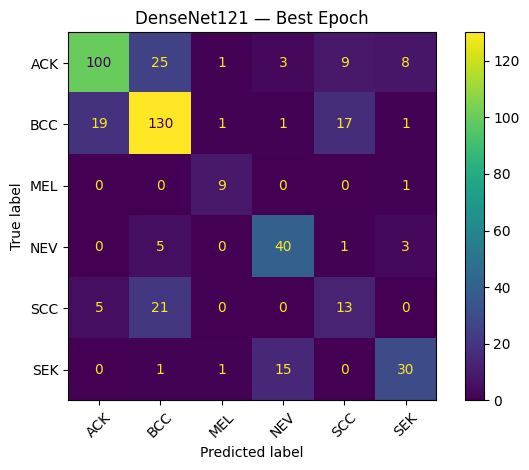

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/pytorch_densenet121_best.pth"

evaluate_model_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_name="densenet121",
    num_classes=len(class_names),
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    plot_title=f"DenseNet121 — Best Epoch"
)

**ResNet50V2**


 Classification Report for pytorch_resnet50v2_epoch10.pth:
              precision    recall  f1-score   support

         ACK       0.68      0.82      0.74       146
         BCC       0.69      0.74      0.72       169
         MEL       0.24      1.00      0.39        10
         NEV       0.69      0.63      0.66        49
         SCC       0.00      0.00      0.00        39
         SEK       0.67      0.26      0.37        47

    accuracy                           0.65       460
   macro avg       0.50      0.57      0.48       460
weighted avg       0.62      0.65      0.61       460



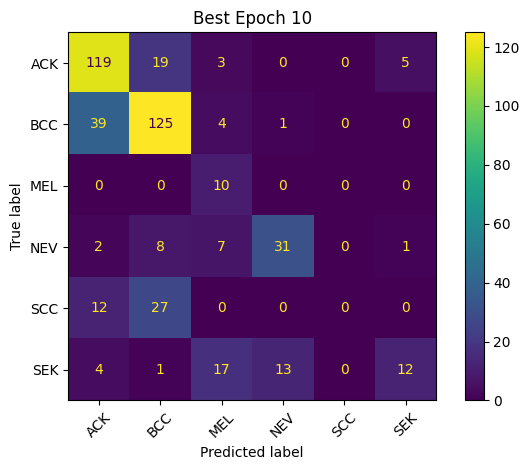

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/Final Year Project/Code/Image Classification/ResNet50V2/pytorch_resnet50v2_best.pth"

evaluate_model_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_name="resnetv2_50x1_bit.goog_in21k_ft_in1k",
    num_classes=len(class_names),
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    plot_title=f"Best Epoch"
)

**EfficientNetV2**


 Classification Report for pytorch_efficientnetv2s_best.pth:
              precision    recall  f1-score   support

         ACK       0.82      0.77      0.79       146
         BCC       0.80      0.80      0.80       169
         MEL       0.60      0.30      0.40        10
         NEV       0.74      0.65      0.70        49
         SCC       0.53      0.51      0.52        39
         SEK       0.54      0.77      0.63        47

    accuracy                           0.74       460
   macro avg       0.67      0.63      0.64       460
weighted avg       0.75      0.74      0.74       460



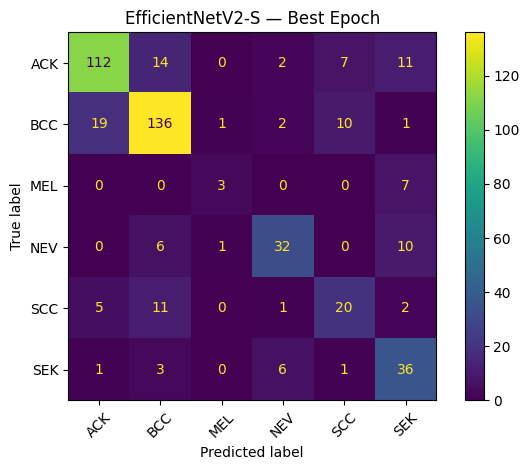

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/Final Year Project/Code/Image Classification/EfficientNetV2/pytorch_efficientnetv2s_best.pth"

evaluate_model_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_name="tf_efficientnetv2_s",
    num_classes=len(class_names),
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    plot_title=f"EfficientNetV2-S — Best Epoch"
)

**Swin-Tiny**


 Classification Report for pytorch_swintiny_best.pth:
              precision    recall  f1-score   support

         ACK       0.54      0.63      0.58       146
         BCC       0.61      0.67      0.64       169
         MEL       0.21      0.90      0.35        10
         NEV       0.85      0.35      0.49        49
         SCC       0.00      0.00      0.00        39
         SEK       0.36      0.32      0.34        47

    accuracy                           0.54       460
   macro avg       0.43      0.48      0.40       460
weighted avg       0.53      0.54      0.52       460



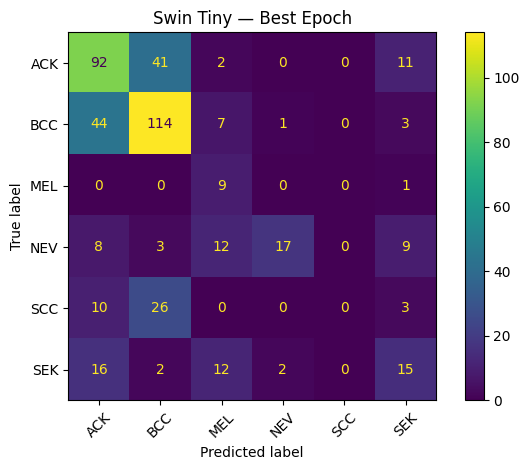

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/Final Year Project/Code/Image Classification/Swin-Tiny/pytorch_swintiny_best.pth"

evaluate_model_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_name="swin_tiny_patch4_window7_224",
    num_classes=len(class_names),
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    plot_title=f"Swin Tiny — Best Epoch"
)

**DeiT-Small**


 Classification Report for pytorch_deitsmall_best.pth:
              precision    recall  f1-score   support

         ACK       0.73      0.81      0.77       146
         BCC       0.75      0.69      0.72       169
         MEL       0.19      1.00      0.32        10
         NEV       0.80      0.57      0.67        49
         SCC       0.34      0.31      0.32        39
         SEK       0.75      0.32      0.45        47

    accuracy                           0.65       460
   macro avg       0.59      0.62      0.54       460
weighted avg       0.70      0.65      0.66       460



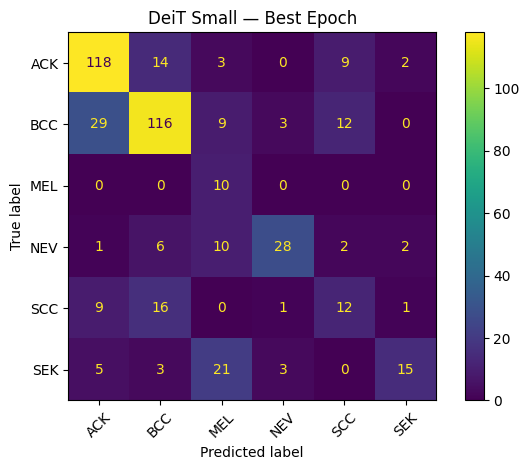

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/Final Year Project/Code/Image Classification/DeiT-Small/pytorch_deitsmall_best.pth"

evaluate_model_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_name="deit_small_patch16_224",
    num_classes=len(class_names),
    val_loader=val_loader,
    device=device,
    class_names=class_names,
    plot_title=f"DeiT Small — Best Epoch"
)